# Intel Image Classification using GRU Model

### 1. Introduction
In this notebook, we use a GRU-based deep learning model to classify images of **buildings** and **streets** from the Intel Image Classification dataset. This model combines CNN-based feature extraction (ResNet50) with an RNN GRU layer to capture spatial dependencies in the extracted features.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
print("All imports work!")

All imports work!


### 2. Dataset Preparation
We selected two classes — **buildings** and **streets** — from the Intel Image Classification dataset available on Kaggle.
The dataset is divided into training, validation, and test sets. Each image is resized to 224×224 pixels and batched with a size of 32.


In [2]:

# Set dataset path (adjust to your local folder)
data_dir = "data"   # your dataset folder

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 4573 files belonging to 2 classes.
Found 3072 files belonging to 2 classes.
Found 938 files belonging to 2 classes.
Classes: ['buildings', 'street']


In [3]:
train_count = tf.data.experimental.cardinality(train_ds).numpy() * BATCH_SIZE
val_count = tf.data.experimental.cardinality(val_ds).numpy() * BATCH_SIZE
test_count = tf.data.experimental.cardinality(test_ds).numpy() * BATCH_SIZE

print(f"Training images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")


Training images: 4576
Validation images: 3072
Test images: 960


### 3. Sample Images from Dataset
Below are some randomly selected images from the dataset for each class. 


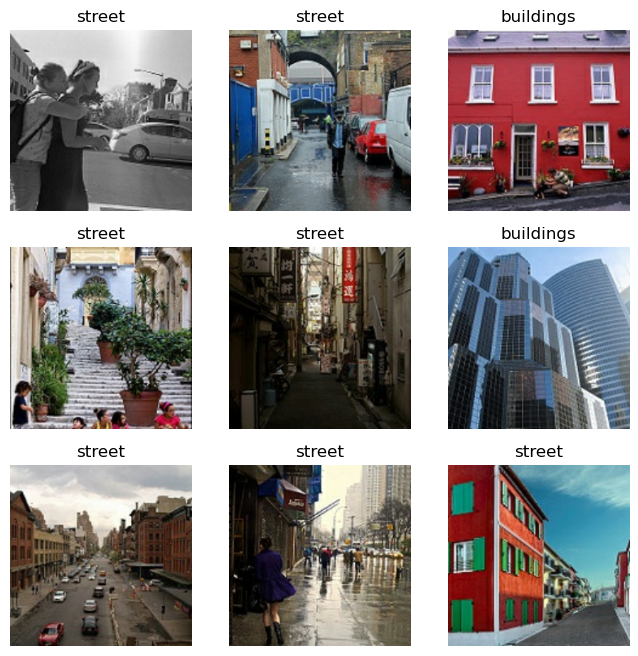

In [4]:

plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")


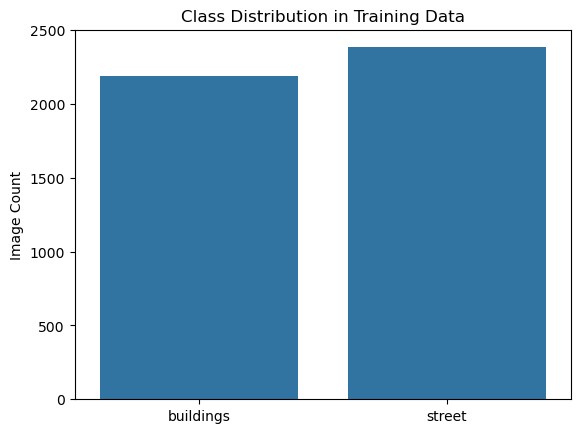

In [5]:
# Count number of samples per class
count_dict = {class_name: len(os.listdir(os.path.join(data_dir, 'train', class_name))) 
              for class_name in class_names}
sns.barplot(x=list(count_dict.keys()), y=list(count_dict.values()))
plt.title("Class Distribution in Training Data")
plt.ylabel("Image Count")
plt.show()


### 4. Model Architecture
I use the pre-trained **ResNet50** model (trained on ImageNet) as a feature extractor. The convolutional layers are frozen to retain learned spatial representations.
The extracted feature maps are reshaped into sequences and passed into a **GRU layer** (128 units) to capture sequential dependencies.
Finally, a dense layer with sigmoid activation performs binary classification.



In [6]:

cnn_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
cnn_base.trainable = False   # freeze CNN initially

inputs = layers.Input(shape=(224,224,3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = cnn_base(x, training=False)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Reshape((-1, x.shape[-1]))(x)  # convert feature map to sequence
x = layers.GRU(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_gru = models.Model(inputs, outputs)
model_gru.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_gru.summary()

from tensorflow.keras.utils import plot_model
plot_model(model_gru, show_shapes=True, to_file="model_structure.png")



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 2048)       0         
 ooling2D)                                                       
                                                                 
 reshape (Reshape)           (None, 9, 2048)           0     

GRU is computationally efficient compared to LSTM while maintaining the ability to learn long-term dependencies.

### 5. Model Training
The GRU model is trained for 10 epochs using the **Adam optimizer** and **binary cross-entropy loss**.
I monitor both training and validation accuracy to detect overfitting.


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_gru.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
143/143 [==============================] - 664s 5s/step - loss: 0.1878 - accuracy: 0.9250 - val_loss: 0.1043 - val_accuracy: 0.9648
Epoch 2/10
143/143 [==============================] - 479s 3s/step - loss: 0.1344 - accuracy: 0.9499 - val_loss: 0.0787 - val_accuracy: 0.9743
Epoch 3/10
143/143 [==============================] - 443s 3s/step - loss: 0.1037 - accuracy: 0.9635 - val_loss: 0.0551 - val_accuracy: 0.9821
Epoch 4/10
143/143 [==============================] - 457s 3s/step - loss: 0.0672 - accuracy: 0.9759 - val_loss: 0.0401 - val_accuracy: 0.9870
Epoch 5/10
143/143 [==============================] - 480s 3s/step - loss: 0.0485 - accuracy: 0.9838 - val_loss: 0.0212 - val_accuracy: 0.9941
Epoch 6/10
143/143 [==============================] - 622s 4s/step - loss: 0.0280 - accuracy: 0.9928 - val_loss: 0.0112 - val_accuracy: 0.9967
Epoch 7/10
143/143 [==============================] - 527s 4s/step - loss: 0.0189 - accuracy: 0.9945 - val_loss: 0.0064 - val_accuracy: 0.9987

### 6. Performance Visualization
The training and validation accuracy/loss curves are shown below to visualize the model's learning process.


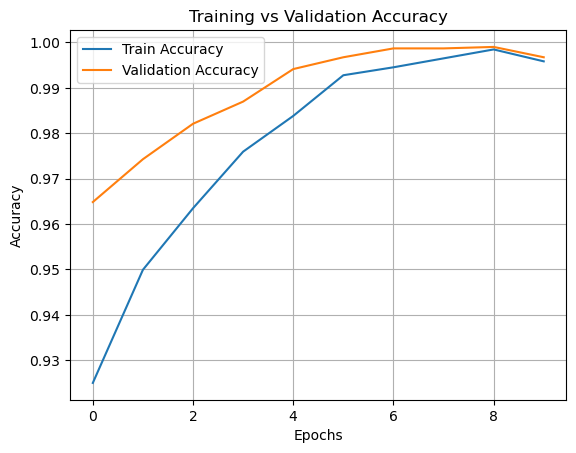

In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


### 7. Model Evaluation on Test Data
The model is evaluated on unseen test data to measure generalization performance. I calculate the classification report and confusion matrix.


In [9]:
test_loss, test_acc = model_gru.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

y_true, y_pred = [], []
for x_batch, y_batch in test_ds:
    preds = model_gru.predict(x_batch)
    y_true.extend(y_batch.numpy())
    y_pred.extend((preds > 0.5).astype("int32").ravel())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


30/30 [==============================] - 50s 2s/step - loss: 0.1960 - accuracy: 0.9435
Test Accuracy: 0.9435
1/1 [==============================] - 6s 6s/step

Classification Report:

              precision    recall  f1-score   support

   buildings       0.96      0.92      0.94       437
      street       0.93      0.97      0.95       501

    accuracy                           0.94       938
   macro avg       0.95      0.94      0.94       938
weighted avg       0.94      0.94      0.94       938



### 8. Confusion Matrix
The confusion matrix below shows the number of correctly and incorrectly classified samples for each class.


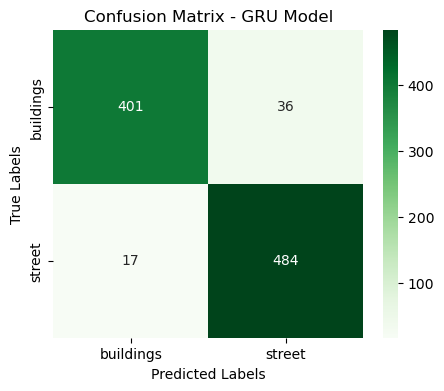

In [10]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - GRU Model")
plt.show()



### 9. Model Saving


In [11]:

model_gru.save("gru_buildings_street.h5")
print("Model saved!")


Model saved!


## 10. Discussion and Future Work 

The GRU model achieved promising results in classifying images between **buildings** and **streets**.  
While the accuracy is satisfactory, further improvements can be made by:

- Increasing training epochs or using fine-tuning of the CNN base (unfreezing top layers).  
- Using a hybrid **CNN + GRU** model for feature enhancement.  
- Applying more aggressive data augmentation.  
- Experimenting with **LSTM** or **CNN-only models** for comparison.

### Future Work
In the future, this approach can be extended to all six classes in the Intel dataset to evaluate scalability and model generalization.
